<a href="https://www.kaggle.com/code/patimejia/contrail-animation-with-mask-overlaid?scriptVersionId=137800497" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

[DEBUG] Running main function with base_dir=/kaggle/input/google-research-identify-contrails-reduce-global-warming/train and record_id=1704010292581573769
[DEBUG] Loading numpy array for band: band_11
[DEBUG] Loaded band: band_11 with shape (256, 256, 8)
[DEBUG] Loading numpy array for band: band_14
[DEBUG] Loaded band: band_14 with shape (256, 256, 8)
[DEBUG] Loading numpy array for band: band_15
[DEBUG] Loaded band: band_15 with shape (256, 256, 8)
[DEBUG] Loading numpy array for band: human_pixel_masks
[DEBUG] Loaded band: human_pixel_masks with shape (256, 256, 1)
[DEBUG] Loading numpy array for band: human_individual_masks
[DEBUG] Loaded band: human_individual_masks with shape (256, 256, 1, 4)
[DEBUG] Normalizing band data with bounds: (-4, 2)
[DEBUG] Normalizing band data with bounds: (-4, 5)
[DEBUG] Normalizing band data with bounds: (243, 303)
[DEBUG] Displaying image.
[DEBUG] Animating image.


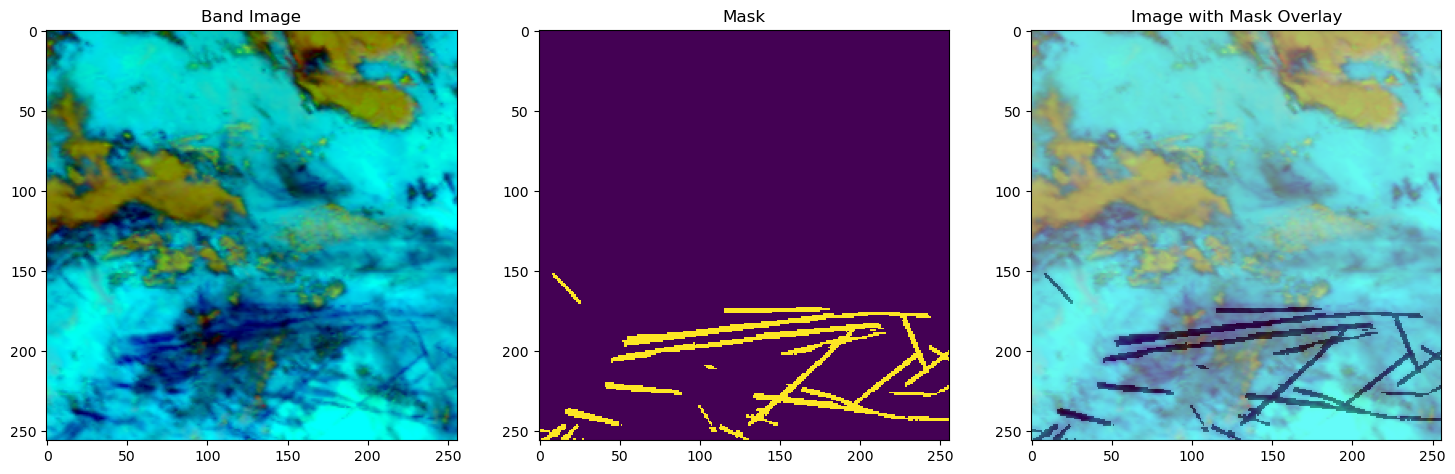

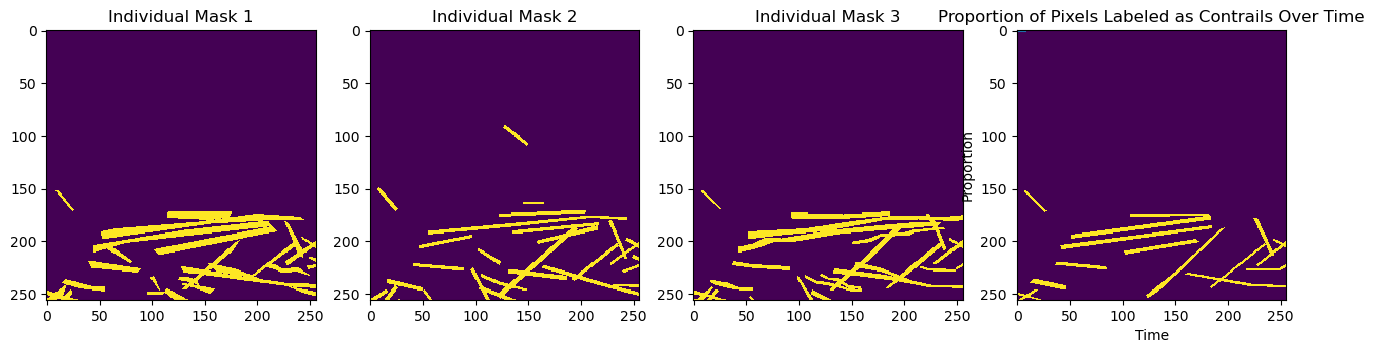

In [7]:
import os
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML

# CONSTANTS
_N_TIMES_BEFORE = 4
_BOUNDS = {
    'band_11': (243, 303),
    'band_14': (-4, 2),
    'band_15': (-4, 5)
}
_BANDS = ['band_11', 'band_14', 'band_15', 'human_pixel_masks', 'human_individual_masks']

def print_debug(*args):
    print("[DEBUG]", *args)

def load_band(base_dir, record_id, band):
    print_debug(f"Loading numpy array for band: {band}")
    band_path = os.path.join(base_dir, record_id, f'{band}.npy')
    with open(band_path, 'rb') as f:
        band_data = np.load(f)
    print_debug(f"Loaded band: {band} with shape {band_data.shape}")
    return band_data

def normalize_band(band_data, bounds):
    print_debug(f"Normalizing band data with bounds: {bounds}")
    normalized_data = (band_data - bounds[0]) / (bounds[1] - bounds[0])
    return normalized_data

def display_image(img, mask, individual_masks):
    print_debug("Displaying image.")
    plt.figure(figsize=(18, 6))

    ax = plt.subplot(1, 3, 1)
    ax.imshow(img)
    ax.set_title('Band Image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(mask, interpolation='none')
    ax.set_title('Mask')

    ax = plt.subplot(1, 3, 3)
    ax.imshow(img)
    ax.imshow(mask, cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Image with Mask Overlay')

    n = individual_masks.shape[-1]
    plt.figure(figsize=(16, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(individual_masks[..., i], interpolation='none')
        plt.title(f'Individual Mask {i+1}')

def animate_image(img, mask):
    print_debug("Animating image.")
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(img[..., 0], cmap='gray')
    overlay = ax.imshow(mask[..., 0], cmap='jet', alpha=0.5)  # Overlay the mask with transparency

    ax.set_title('False Color Band Animation Over Time')
    ax.set_xlabel('Spacial dim: X Coordinate')
    ax.set_ylabel('Spacial dim: Y Coordinate')

    def draw(i):
        im.set_array(img[..., i])
        overlay.set_array(mask[..., i])
        return [im, overlay]

    anim = FuncAnimation(
        fig, draw, frames=img.shape[-1], interval=500, blit=True
    )

    plt.close(fig)
    return anim

def calculate_contrail_proportions(mask):
    proportions = np.mean(mask, axis=(0, 1))
    plt.plot(proportions)
    plt.title('Proportion of Pixels Labeled as Contrails Over Time')
    plt.xlabel('Time')
    plt.ylabel('Proportion')
    plt.show()

def calculate_dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (np.sum(y_true) + np.sum(y_pred) + 1.)

def main(base_dir, record_id):
    print_debug(f"Running main function with base_dir={base_dir} and record_id={record_id}")

    # Load band data (from the first version for clarity)
    band11 = load_band(base_dir, record_id, 'band_11')
    band14 = load_band(base_dir, record_id, 'band_14')
    band15 = load_band(base_dir, record_id, 'band_15')
    human_pixel_mask = load_band(base_dir, record_id, 'human_pixel_masks')
    human_individual_mask = load_band(base_dir, record_id, 'human_individual_masks')

    # Normalization and false color image generation (from the second version for efficiency)
    r = normalize_band(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_band(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_band(band14, _T11_BOUNDS)
    false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)

    # Check if mask has the same number of frames as false_color and repeat if necessary (enhancement)
    num_frames = false_color.shape[-1]
    if human_pixel_mask.shape[-1] == 1:
        human_pixel_mask = np.repeat(human_pixel_mask, num_frames, axis=-1)

    # Extract a single frame from the mask for display
    displayed_mask = human_pixel_mask[..., _N_TIMES_BEFORE]

    # Call the display and animation functions
    display_image(false_color[..., _N_TIMES_BEFORE], displayed_mask, human_individual_mask)
    animation = animate_image(false_color, human_pixel_mask)
    calculate_contrail_proportions(human_pixel_mask)

    # Calculate Dice coefficient on validation set (commented out since we don't have a model prediction)
    # y_pred = model.predict(band_data)  
    # y_true = human_pixel_mask.flatten()
    # dice_coeff = calculate_dice_coefficient(y_true, y_pred)
    # print(f'Dice coefficient on validation set: {dice_coeff}')

    return animation

# Call the main function with the base directory and record id as arguments
base_dir = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'
record_id = '1704010292581573769'
animation = main(base_dir, record_id)

# Display the animation in the notebook
HTML(animation.to_jshtml())

# Mask Overlay in Animations Seeks to Offer:
- **Immediate Validation:** Directly compare mask with actual imagery.
- **Clear Contrail Tracking:** Easily observe when and where human mask detects contrails and its subsequent trajectory shifts.
- **Temporal Dynamics:** Highlights contrail evolution over frames.
- **Debugging Aid:** Offers visual feedback on detection precision.

# Previous Ash Color Animation (no mask overlay):

[DEBUG] Running main function with base_dir=/kaggle/input/google-research-identify-contrails-reduce-global-warming/train and record_id=1704010292581573769
[DEBUG] Loading numpy array for band: band_11
[DEBUG] Loaded band: band_11 with shape (256, 256, 8)
[DEBUG] Loading numpy array for band: band_14
[DEBUG] Loaded band: band_14 with shape (256, 256, 8)
[DEBUG] Loading numpy array for band: band_15
[DEBUG] Loaded band: band_15 with shape (256, 256, 8)
[DEBUG] Loading numpy array for band: human_pixel_masks
[DEBUG] Loaded band: human_pixel_masks with shape (256, 256, 1)
[DEBUG] Loading numpy array for band: human_individual_masks
[DEBUG] Loaded band: human_individual_masks with shape (256, 256, 1, 4)
[DEBUG] Normalizing band data with bounds: (-4, 2)
[DEBUG] Normalization complete. Data min: -0.8434651494026184, max: 0.6381454467773438
[DEBUG] Normalizing band data with bounds: (-4, 5)
[DEBUG] Normalization complete. Data min: -0.3408440351486206, max: 1.4984571933746338
[DEBUG] Normaliz

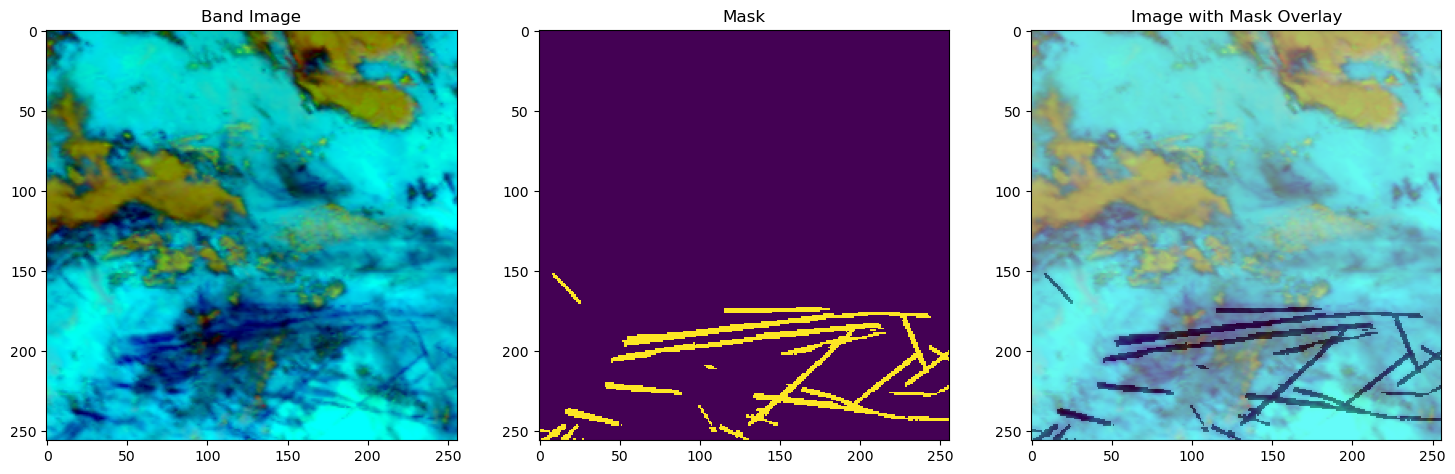

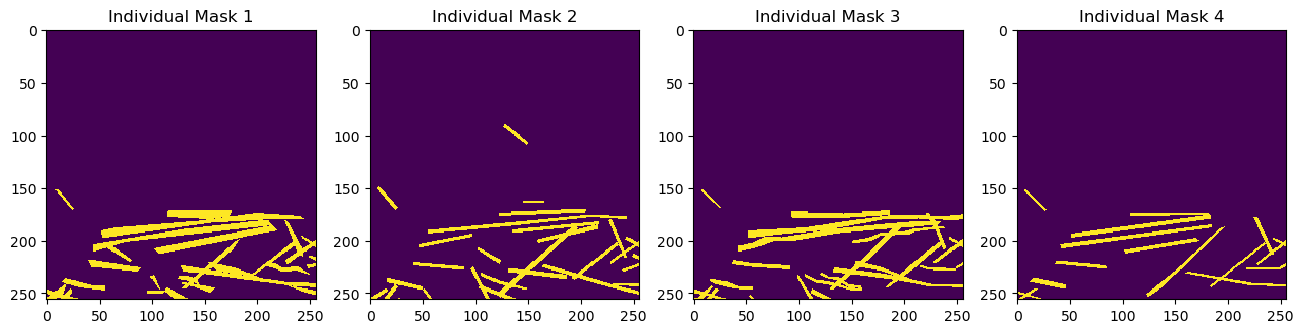

In [8]:
import os
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML

# CONSTANTS
_N_TIMES_BEFORE = 4
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)
_BANDS = ['band_11', 'band_14', 'band_15', 'human_pixel_masks', 'human_individual_masks']

def print_debug(*args):
    # Prints debug messages
    print("[DEBUG]", *args)

def load_band(base_dir, record_id, band):
    # Loads band data from file
    print_debug(f"Loading numpy array for band: {band}")
    band_path = os.path.join(base_dir, record_id, f'{band}.npy')
    with open(band_path, 'rb') as f:
        band_data = np.load(f)
    print_debug(f"Loaded band: {band} with shape {band_data.shape}")
    return band_data

def normalize_band(band_data, bounds):
    # Normalizes band data using given bounds
    print_debug(f"Normalizing band data with bounds: {bounds}")
    normalized_data = (band_data - bounds[0]) / (bounds[1] - bounds[0])
    print_debug(f"Normalization complete. Data min: {normalized_data.min()}, max: {normalized_data.max()}")
    return normalized_data

def display_image(img, mask, individual_masks):
    # Displays image and masks
    print_debug("Displaying image.")
    plt.figure(figsize=(18, 6))

    ax = plt.subplot(1, 3, 1)
    ax.imshow(img)
    ax.set_title('Band Image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(mask, interpolation='none')
    ax.set_title('Mask')

    ax = plt.subplot(1, 3, 3)
    ax.imshow(img)
    ax.imshow(mask, cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Image with Mask Overlay')

    n = individual_masks.shape[-1]
    plt.figure(figsize=(16, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(individual_masks[..., i], interpolation='none')
        plt.title(f'Individual Mask {i+1}')

def animate_image(img):
    # Animates image using matplotlib
    print_debug("Animating image.")
    fig = plt.figure(figsize=(6, 6))
    im = plt.imshow(img[..., 0])

    def draw(i):
        im.set_array(img[..., i])
        return [im]

    anim = animation.FuncAnimation(
        fig, draw, frames=img.shape[-1], interval=500, blit=True
    )
    
    plt.close(fig)
    print_debug("Animation created.")
    return HTML(anim.to_jshtml())

def main(base_dir, record_id):
    # Main function to load and display data
    print_debug(f"Running main function with base_dir={base_dir} and record_id={record_id}")
    
    band11 = load_band(base_dir, record_id, 'band_11')
    band14 = load_band(base_dir, record_id, 'band_14')
    band15 = load_band(base_dir, record_id, 'band_15')
    human_pixel_mask = load_band(base_dir, record_id, 'human_pixel_masks')
    human_individual_mask = load_band(base_dir, record_id, 'human_individual_masks')

    r = normalize_band(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_band(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_band(band14,_T11_BOUNDS)

    false_color = np.clip(np.stack([r,g,b], axis=2),0 ,1)

    img=false_color[..., _N_TIMES_BEFORE]

    display_image(img,human_pixel_mask,human_individual_mask)
    return animate_image(false_color)

# Call the main function with the base directory and record id as arguments
animation=main('/kaggle/input/google-research-identify-contrails-reduce-global-warming/train','1704010292581573769')
animation

<h2 id="credit-goes-to-all-authors-and-contributors">🥇 Credit goes to all authors and contributors ⤵︎ </h2>

- This script is inspired by [INVERSION's notebook on Kaggle](https://www.kaggle.com/code/inversion/visualizing-contrails).
- How to create the standard RGB images: [Compilation of RGB Recipes (i.e. Ash RGB)](https://eumetrain.org/sites/default/files/2020-05/RGB_recipes.pdf)
- This script is inspired by [Google Research - Identify Contrails to Reduce Global Warming](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming)
---
## Appendix:
- [GitHub: src/utils/contrail_animation](https://github.com/patmejia/contrails-vision/blob/main/src/utils/contrail_animation.py): execute the Python code locally.



## Appendix: Analysis of Atmospheric Absorptivity and Earth's Radiation Emission
- Study of absorptivity in gases: O2, O3, N2O, CO2, H2O, CH4.
- Examination of Earth's radiation emission.
- Details on color channels, ash RGB range, and temperature range for IR10.8 and IR12.0 satellite imagery.


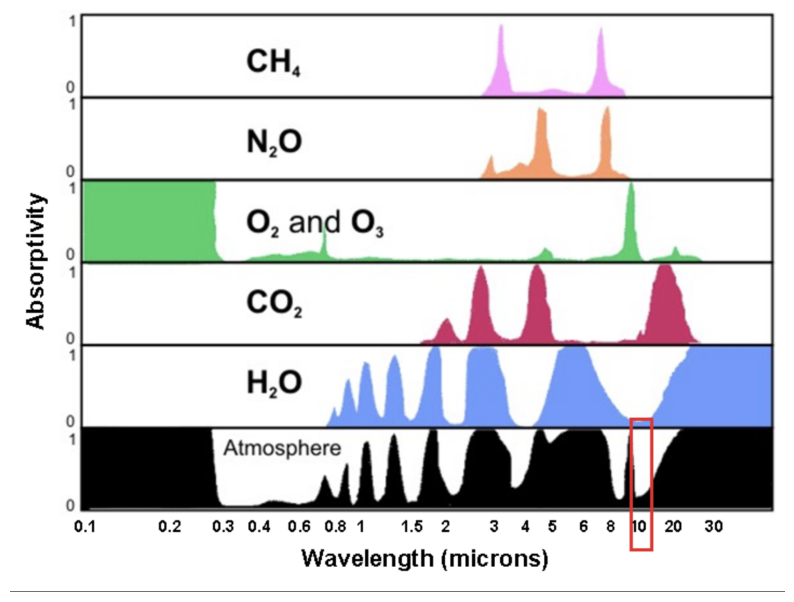

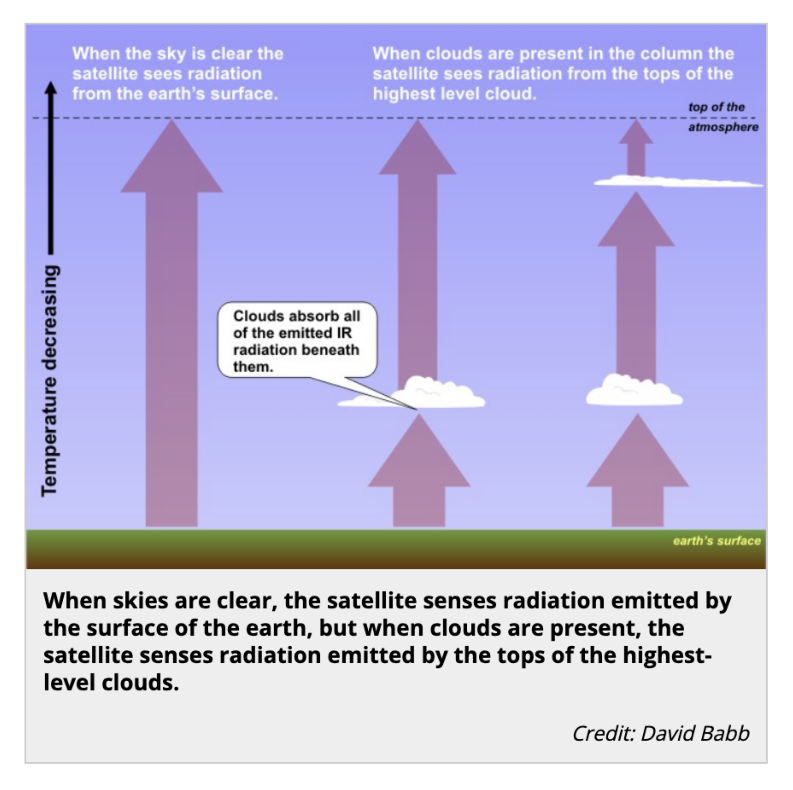

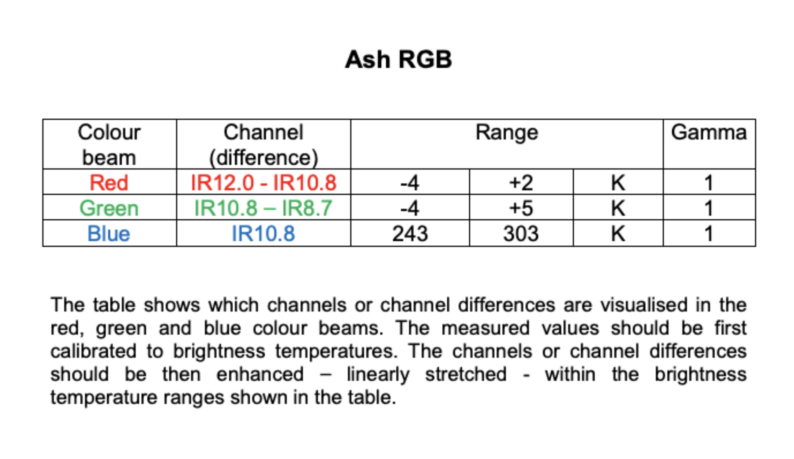

In [9]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

text = """
## Appendix: Analysis of Atmospheric Absorptivity and Earth's Radiation Emission
- Study of absorptivity in gases: O2, O3, N2O, CO2, H2O, CH4.
- Examination of Earth's radiation emission.
- Details on color channels, ash RGB range, and temperature range for IR10.8 and IR12.0 satellite imagery.
"""

display(Markdown(text))

images = [
    '/kaggle/input/contrail-vision-research-related-images-docs/atmospheric-gases-absorptivity.png',
    '/kaggle/input/contrail-vision-research-related-images-docs/satellite-sensing-radiation.png',
    '/kaggle/input/contrail-vision-research-related-images-docs/ash-rgb.png'
]

for img_path in images:
    img = mpimg.imread(img_path)
    plt.figure(figsize=(10,10)) # you can adjust the size as per your requirement
    plt.imshow(img)
    plt.axis('off')
    plt.show()

<div style="background-color: #f2f2f2; padding: 53px; border-radius: 5px;">
  <h3>If you found this notebook helpful...</h3>
  <p>
  Please consider giving it a star. Your support helps me continue to develop high-quality code and pursue my career as a data analyst/engineer. Feedback is always welcome and appreciated. Thank you for taking the time to read my work! 
  </p> 
  <h4>
  <p style="text-align: right;">
  <a href="https://github.com/patmejia"> - pat [¬º-°]¬ </a>
  </h4>
  </p>
</div>